### Wavelet-bandwise Transformation

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import copy

import sys
sys.path.append('../artifact')

In [19]:
# Load Real and Recon Images
real_img = Image.open('../artifact/real.JPEG').convert('RGB')
recon_img = Image.open('../artifact/recon.JPEG').convert('RGB')
real_rgb = np.array(real_img).astype(np.float32) / 255.00
recon_rgb = np.array(recon_img).astype(np.float32) / 255.00

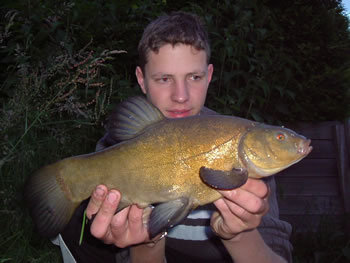

In [22]:
real_img

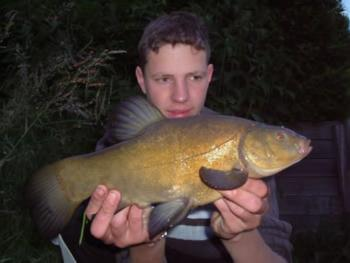

In [32]:
recon_img

In [21]:
H, W, C = real_rgb.shape
H, W, C

(263, 350, 3)

### Haar Decomposition

In [23]:
def pad_even(arr):
    h, w = arr.shape[:2]
    pad_h = (2 - h % 2) % 2
    pad_w = (2 - w % 2) % 2

    if pad_h or pad_w:
        arr = np.pad(arr, ((0, pad_h), (0, pad_w), (0, 0)))
    return arr

In [25]:
real_rgb = pad_even(real_rgb)
recon_rgb = pad_even(recon_rgb)
H, W = real_rgb.shape[:2]

In [26]:
H, W

(264, 350)

**Note we are Doing this becuz its easier to divide the Image and Recon(&real) Image are off same size**

### Haar transformation 1-D along axis:

In [49]:
def haar_step(channels, axis=0):
    """
    Perform one level of Haar wavelet decomposition along specified axis.
    """
    # Pad to even size before splitting
    if axis == 0:
        if channels.shape[0] % 2 != 0:
            channels = np.pad(channels, ((0, 1), (0, 0)), mode='edge')
        evens = channels[::2, :]
        odds = channels[1::2, :]
    else:
        if channels.shape[1] % 2 != 0:
            channels = np.pad(channels, ((0, 0), (0, 1)), mode='edge')
        evens = channels[:, ::2]
        odds = channels[:, 1::2]
    
    L = (evens + odds) / np.sqrt(2)
    H = (evens - odds) / np.sqrt(2)
    
    return L, H


#### 2D Fully Seperable WaveLet Decomp
**Decomp along x and then y on each x-band**

In [50]:
def wavedec_2d(channels, level=3):
    
    # Decomp along X (cols)
    x_coeffs = []
    curr_x = channels.copy()
    for _ in range(level):
        curr_x, h_x = haar_step(curr_x, axis=1)
        x_coeffs.append(h_x)
    x_coeffs.append(curr_x) # Append final low-pass L3-X
    x_coeffs = x_coeffs[::-1] # ReOrdered: [L3-X, H3-X, H2-X, H1-X]

    # Decompose along Y-axis for each of x-band
    y_coeffs = []
    for x_band in x_coeffs:
        y_bands = []
        curr_y = x_band.copy()
        for _ in range(level):
            curr_y, h_y = haar_step(curr_y, axis=0)
            y_bands.append(h_y)
        y_bands.append(curr_y) # Append final low-pass L3-Y
        y_bands = y_bands[::-1] # ReOrdered: [L3-Y, H3-Y, H2-Y, H1-Y]
        y_coeffs.append(y_bands)
    return y_coeffs

### haar Inverse step (1-D along axis)

In [65]:
def haar_istep(L, H, axis=1):
    """
    Inverse Haar wavelet step.
    """
    # Ensure L and H have same shape
    if axis == 1:  # Columns
        min_cols = min(L.shape[1], H.shape[1])
        L = L[:, :min_cols]
        H = H[:, :min_cols]
        recon = np.zeros((L.shape[0], 2 * min_cols))
        recon[:, 0::2] = (L + H) / np.sqrt(2)
        recon[:, 1::2] = (L - H) / np.sqrt(2)
    else:  # Rows
        min_rows = min(L.shape[0], H.shape[0])
        L = L[:min_rows, :]
        H = H[:min_rows, :]
        recon = np.zeros((2 * min_rows, L.shape[1]))
        recon[0::2, :] = (L + H) / np.sqrt(2)
        recon[1::2, :] = (L - H) / np.sqrt(2)
    
    return recon


### 2D-Inverse Wavelet Transform

In [66]:
def waveinv_2d(y_coeffs, orig_shape):
    
    # Inverse y-decomp first (per x-band)
    x_recons = []
    for y_bands in y_coeffs:
        recon_y = y_bands[0].copy() # Start with L_Y
        for lvl in range(1, 4): # Reconstructed H1_y to H3_y
            h_y = y_bands[lvl]
            recon_y = haar_istep(recon_y, h_y, axis=0)
        x_recons.append(recon_y)

    # Inverse x-decomp
    recon_x = x_recons[0].copy() # Start with L3_X
    for lvl in range(1, 4):
        h_x = x_recons[lvl]
        recon_x = haar_istep(recon_x, h_x, axis=1)

    # crop to original shape (reverse padding)
    return recon_x[:orig_shape[0], :orig_shape[1]]

    



**Wavelet Band Replacement: Replace Low-freq bands (base LL + HL + VL)**
**Preserve diagonal mid-high HH Bands**


In [67]:
def replace_low_freq_bands(bands_fake, bands_real, variant):
    """Replace low-frequency bands based on variant."""
    bands_aug = [[y_bands[:] for y_bands in x_band] for x_band in bands_fake]

    if variant >= 1:
        # variant 1: replace only base LL (x=0, y=0)
        bands_aug[0][0] = bands_real[0][0].copy()

    if variant >= 2:
        # variant 2: replace all low-freq (LL + LH + HL across levels)
        # LH: vertical high (x=0, L_X, y=1-3 H_y)
        for y_idx in range(1, 4):
            bands_aug[0][y_idx] = bands_real[0][y_idx].copy()
        
        # HL: horizontal high (x=1-3, y=0)
        for x_idx in range(1, 4):
            bands_aug[x_idx][0] = bands_real[x_idx][0].copy()

    return bands_aug


In [68]:
# Decompose real and fake (per channel)
bands_real_per_ch = [wavedec_2d(real_rgb[:, :, ch]) for ch in range(C)]
bands_fake_per_ch = [wavedec_2d(recon_rgb[:, :, ch]) for ch in range(C)]

#### Generate Augmented variants {0: no replace, 1: LL only, 2:full low-freq}

In [69]:
variants = {}
for v in [0, 1, 2]:
    aug_channels = []
    for ch in range(C):
        aug_bands_ch = replace_low_freq_bands(bands_fake_per_ch[ch],
                                              bands_real_per_ch[ch],
                                              v)
        aug_ch = waveinv_2d(aug_bands_ch, (H, W))
        aug_channels.append(aug_ch)
    aug_img = np.stack(aug_channels, axis=-1)

    # Crop Padding
    aug_img = aug_img[:real_rgb.shape[0], :real_rgb.shape[1]]
    variants[v] = aug_img

#### Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.396994499247572e-16..0.9999999999999989].


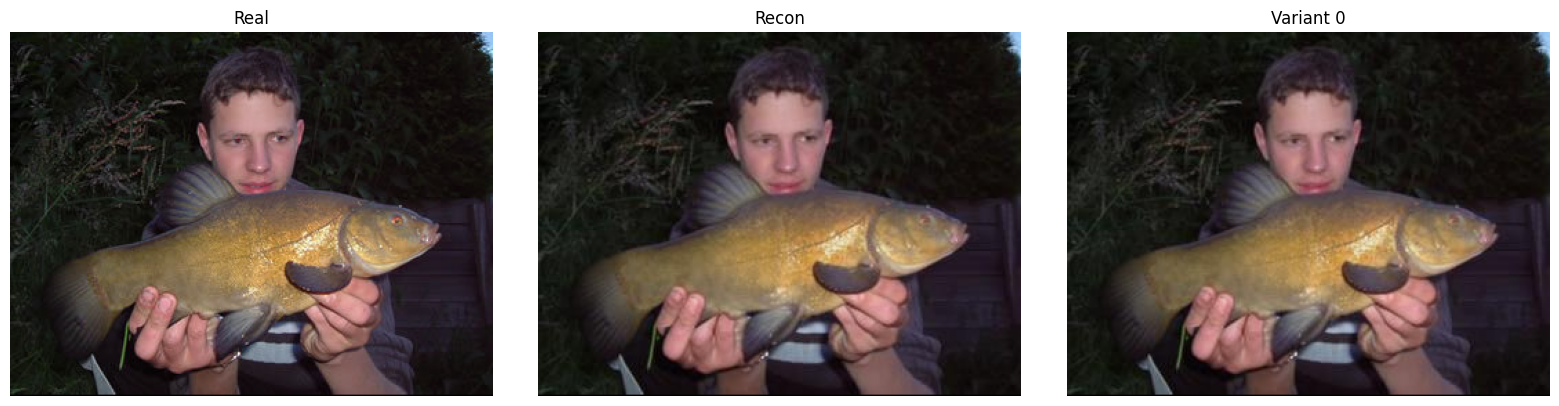

In [72]:
fig, axis = plt.subplots(1, 3, figsize=(16, 4))
axis[0].imshow(real_rgb); axis[0].set_title("Real"); axis[0].axis('off')
axis[1].imshow(recon_rgb); axis[1].set_title("Recon"); axis[1].axis('off')
axis[2].imshow(variants[0]); axis[2].set_title("Variant 0"); axis[2].axis('off')
plt.tight_layout()
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.06813725890242493..1.0428308453410857].


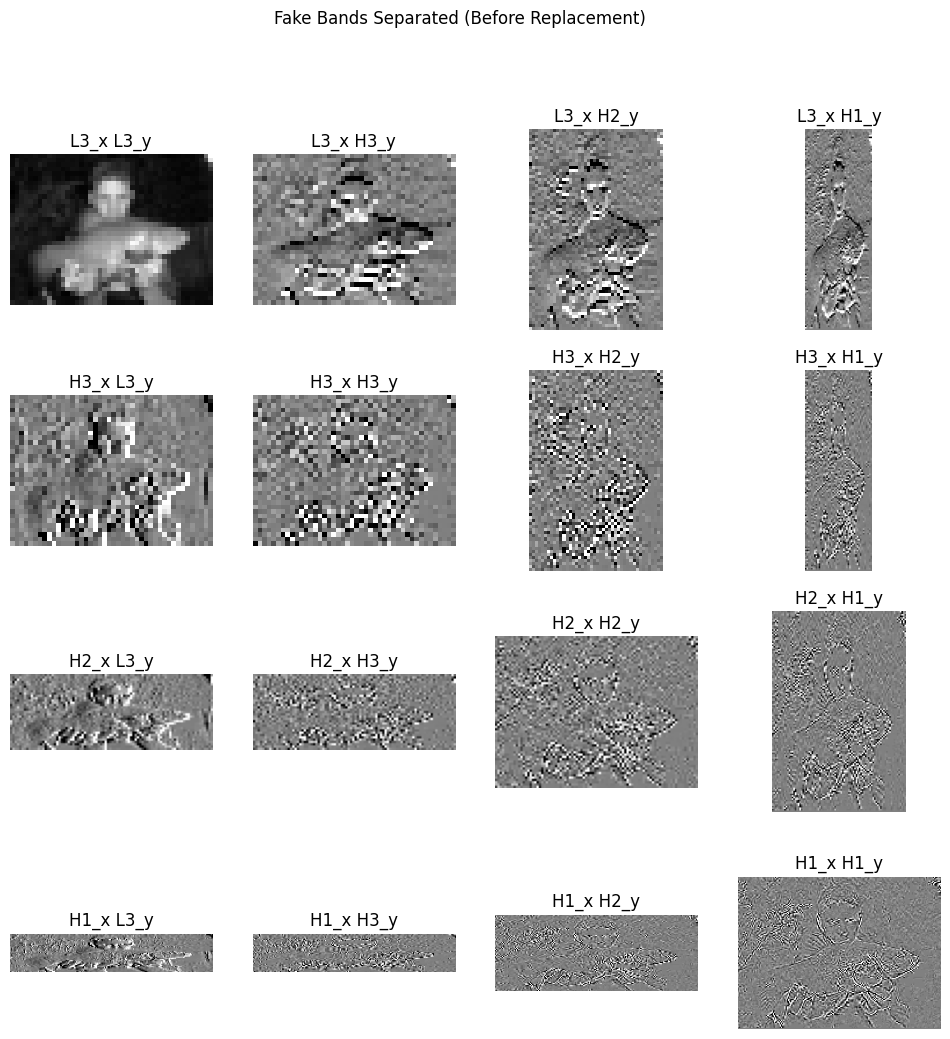

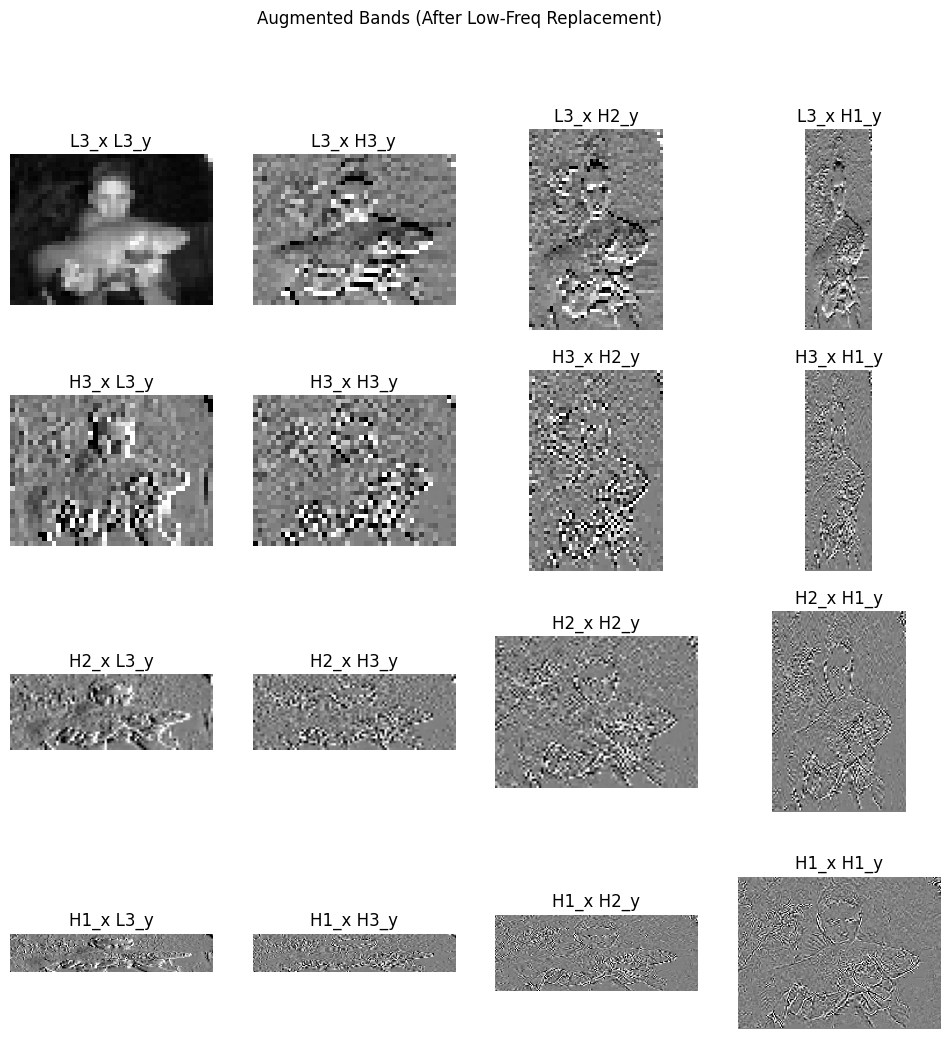

Recon error for channel 0 (should be near 0): 3.378920385898963e-09


In [74]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load real and fake images (replace with your file paths)
real_img = Image.open('../artifact/real.JPEG').convert('RGB')
fake_img = Image.open('../artifact/recon.JPEG').convert('RGB')  # Your recon/fake
real_rgb = np.array(real_img).astype(np.float32) / 255.0
fake_rgb = np.array(fake_img).astype(np.float32) / 255.0
H_orig, W_orig, C = real_rgb.shape

# Pad to even dimensions for clean Haar decomposition
def pad_even(arr):
    h, w = arr.shape[:2]
    pad_h = (2 - h % 2) % 2
    pad_w = (2 - w % 2) % 2
    if pad_h or pad_w:
        arr = np.pad(arr, ((0, pad_h), (0, pad_w), (0, 0)), mode='edge')
    return arr

real_rgb = pad_even(real_rgb)
fake_rgb = pad_even(fake_rgb)
H, W = real_rgb.shape[:2]  # Updated after padding

# Haar forward step (1D along axis)
def haar_step(data, axis):
    if axis == 1:  # Columns (x)
        evens = data[:, 0::2]
        odds = data[:, 1::2]
        if odds.shape[1] < evens.shape[1]:
            odds = np.pad(odds, ((0, 0), (0, 1)), mode='edge')
    else:  # Rows (y)
        evens = data[0::2]
        odds = data[1::2]
        if odds.shape[0] < evens.shape[0]:
            odds = np.pad(odds, ((0, 1), (0, 0)), mode='edge')
    L = (evens + odds) / np.sqrt(2)
    H = (evens - odds) / np.sqrt(2)
    return L, H

# 2D Fully Separable Wavelet Decomposition (Haar, 3 levels)
# Decomposes along x (columns) first, then y (rows) on each x-band
def wavedec_2d(channel, level=3):
    # Decompose along x (columns)
    x_coeffs = []
    curr_x = channel.copy()
    for _ in range(level):
        curr_x, h_x = haar_step(curr_x, axis=1)
        x_coeffs.append(h_x)
    x_coeffs.append(curr_x)  # Append final low-pass L3_x
    x_coeffs = x_coeffs[::-1]  # Reorder: [L3_x, H3_x, H2_x, H1_x]

    # Decompose along y (rows) for each x-band
    y_coeffs = []
    for x_band in x_coeffs:
        y_bands = []
        curr_y = x_band.copy()
        for _ in range(level):
            curr_y, h_y = haar_step(curr_y, axis=0)
            y_bands.append(h_y)
        y_bands.append(curr_y)  # Append final L_y
        y_bands = y_bands[::-1]  # [L_y, H3_y, H2_y, H1_y]
        y_coeffs.append(y_bands)
    return y_coeffs  # List of 4 x-bands, each with 4 y-subbands

# Haar inverse step (1D along axis)
def haar_istep(L, H, axis=1):
    """
    Inverse Haar wavelet step.
    """
    # Ensure L and H have same shape
    if axis == 1:  # Columns
        min_cols = min(L.shape[1], H.shape[1])
        L = L[:, :min_cols]
        H = H[:, :min_cols]
        recon = np.zeros((L.shape[0], 2 * min_cols))
        evens = (L + H) / np.sqrt(2)
        odds = (L - H) / np.sqrt(2)
        recon[:, 0::2] = evens
        recon[:, 1::2] = odds
    else:  # Rows
        min_rows = min(L.shape[0], H.shape[0])
        L = L[:min_rows, :]
        H = H[:min_rows, :]
        recon = np.zeros((2 * min_rows, L.shape[1]))
        evens = (L + H) / np.sqrt(2)
        odds = (L - H) / np.sqrt(2)
        recon[0::2, :] = evens
        recon[1::2, :] = odds
    
    return recon

# 2D Inverse Wavelet Transform
def waveinv_2d(y_coeffs, orig_shape):
    # Inverse y-decomposition first (per x-band)
    x_recons = []
    for y_bands in y_coeffs:
        recon_y = y_bands[0].copy()  # Start with L_y
        for lvl in range(1, 4):  # Reconstruct H1_y to H3_y
            h_y = y_bands[lvl]
            recon_y = haar_istep(recon_y, h_y, axis=0)
        x_recons.append(recon_y)
    # Inverse x-decomposition
    recon_x = x_recons[0].copy()  # Start with L3_x
    for lvl in range(1, 4):  # Reconstruct H1_x to H3_x
        h_x = x_recons[lvl]
        recon_x = haar_istep(recon_x, h_x, axis=1)
    # Crop to original shape (remove padding)
    return recon_x[:orig_shape[0], :orig_shape[1]]

# Wavelet Band Replacement: Replace low-freq bands (base LL + horizontal HL + vertical LH)
# Preserve diagonal mid-high HH bands
def replace_low_freq_bands(bands_fake, bands_real, variant=2):
    # Deep copy fake bands
    bands_aug = [[y_bands[:] for y_bands in x_band] for x_band in bands_fake]
    # Structure: bands[ x_idx ][ y_idx ] where x_idx=0: L_x (low horiz), 1-3: H_x (high horiz)
    # y_idx=0: L_y (low vert), 1-3: H_y (high vert)
    # LL: x=0, y=0
    # LH (vert): x=0, y=1-3
    # HL (horiz): x=1-3, y=0
    # HH (diag): x=1-3, y=1-3 -- NEVER replace
    if variant >= 1:
        # Variant 1: Replace only base LL (x=0, y=0)
        bands_aug[0][0] = bands_real[0][0].copy()
    if variant >= 2:
        # Variant 2: Replace all low-freq (LL + LH + HL across levels)
        # LH: vertical high (x=0 L_x, y=1-3 H_y)
        for y_idx in range(1, 4):
            bands_aug[0][y_idx] = bands_real[0][y_idx].copy()
        # HL: horizontal high (x=1-3 H_x, y=0 L_y)
        for x_idx in range(1, 4):
            bands_aug[x_idx][0] = bands_real[x_idx][0].copy()
        # Base LL already handled in variant 1
    return bands_aug

# Decompose real and fake (per channel)
bands_real_per_ch = [wavedec_2d(real_rgb[:, :, ch]) for ch in range(C)]
bands_fake_per_ch = [wavedec_2d(fake_rgb[:, :, ch]) for ch in range(C)]

# Function to plot 4x4 band grid
def plot_band_grid(fig, axes, bands_list, title, labels):
    for i in range(4):  # x-bands (rows in grid)
        for j in range(4):  # y-subbands (cols in grid)
            # Average across channels for grayscale display (or stack for RGB)
            band_mean = np.mean([bands_list[ch][i][j] for ch in range(C)], axis=0)
            if i == 0 and j == 0:  # LL base: min-max norm
                disp = (band_mean - band_mean.min()) / (band_mean.max() - band_mean.min() + 1e-8)
            else:  # High freq: zero-center at 0.5, scaled
                std = np.std(band_mean)
                scale = 4 * max(std, 1e-5)
                disp = 0.5 + (band_mean / scale)
                disp = np.clip(disp, 0, 1)
            ax = axes[i, j]
            ax.imshow(disp, cmap='gray')
            ax.set_title(f'{labels[i]}_x {labels[j]}_y')
            ax.axis('off')
    fig.suptitle(title)

# Generate augmented variant 2 (full low-freq replace) and show process
v = 2
aug_channels = []
aug_bands_per_ch = []
for ch in range(C):
    aug_bands_ch = replace_low_freq_bands(bands_fake_per_ch[ch], bands_real_per_ch[ch], v)
    aug_bands_per_ch.append(aug_bands_ch)
    aug_ch = waveinv_2d(aug_bands_ch, (H, W))
    aug_channels.append(aug_ch)
aug_img = np.stack(aug_channels, axis=-1)
# Crop padding
aug_img = aug_img[:H_orig, :W_orig]
fake_rgb_crop = fake_rgb[:H_orig, :W_orig]
real_rgb_crop = real_rgb[:H_orig, :W_orig]

# Visualization: Separation and Stitching
fig_sep, axes_sep = plt.subplots(4, 4, figsize=(12, 12))
labels = ["L3", "H3", "H2", "H1"]
plot_band_grid(fig_sep, axes_sep, bands_fake_per_ch, 'Fake Bands Separated (Before Replacement)', labels)

fig_rep, axes_rep = plt.subplots(4, 4, figsize=(12, 12))
plot_band_grid(fig_rep, axes_rep, aug_bands_per_ch, 'Augmented Bands (After Low-Freq Replacement)', labels)

# Stitched results
fig_res, axes_res = plt.subplots(1, 3, figsize=(15, 5))
axes_res[0].imshow(real_rgb_crop); axes_res[0].set_title('Real (Original)'); axes_res[0].axis('off')
axes_res[1].imshow(fake_rgb_crop); axes_res[1].set_title('Fake (Reconstructed from Bands)'); axes_res[1].axis('off')
axes_res[2].imshow(aug_img); axes_res[2].set_title('Augmented (Stitched After Replacement)'); axes_res[2].axis('off')
fig_res.suptitle('Stitching: Before/After Augmentation')

plt.tight_layout()
plt.savefig('separation_stitching_demo.png', dpi=150, bbox_inches='tight')
plt.show()

# Reconstruction fidelity check
recon_error = np.mean(np.abs(waveinv_2d(bands_fake_per_ch[0], (H, W))[:H_orig, :W_orig] - fake_rgb_crop[:, :, 0]))
print(f'Recon error for channel 0 (should be near 0): {recon_error}')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3738309013483032e-16..0.9999999999999989].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.06813725890242493..1.0428308453410857].


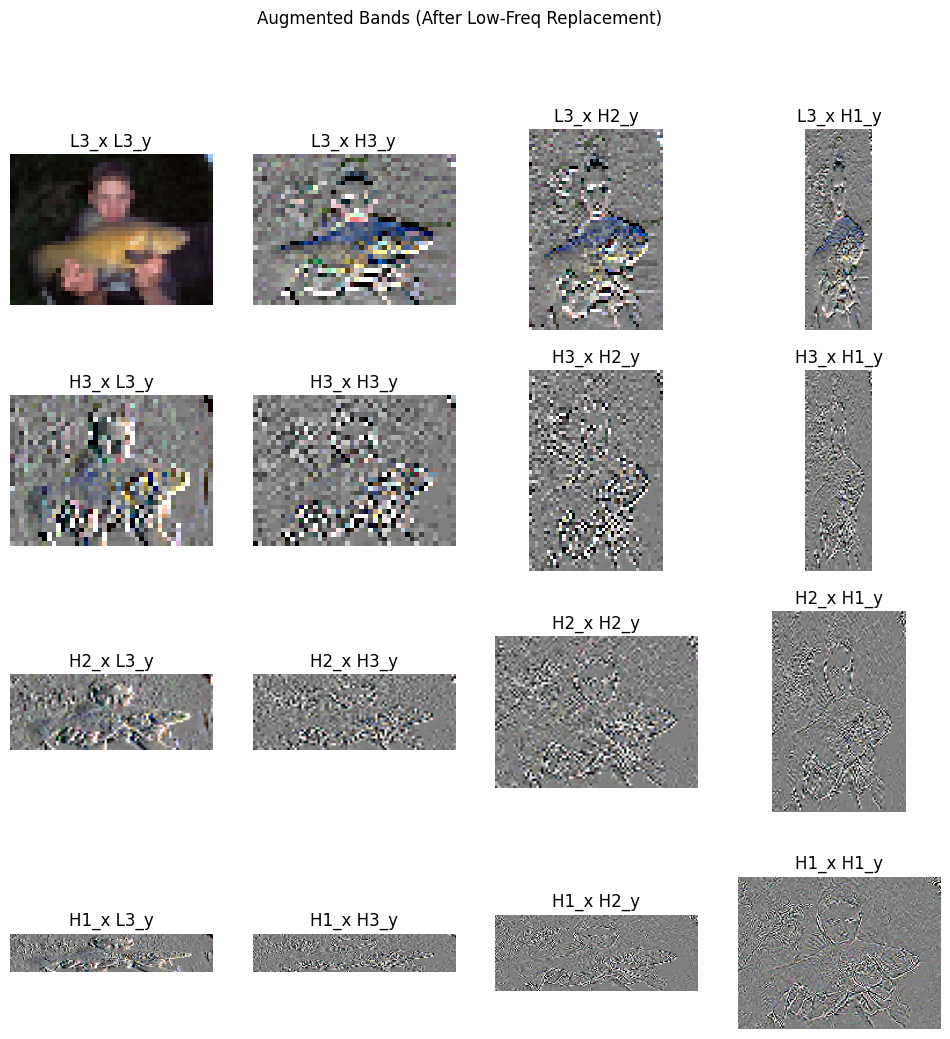

Mean recon error across all 3 channels (should be near 0): 2.229618067340514e-09
Individual channel errors: R=3.378920385898963e-09, G=2.03412800950233e-09, B=1.2758058066202497e-09


In [75]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load real and fake images (replace with your file paths)
real_img = Image.open('../artifact/real.JPEG').convert('RGB')
fake_img = Image.open('../artifact/recon.JPEG').convert('RGB')  # Your recon/fake
real_rgb = np.array(real_img).astype(np.float32) / 255.0
fake_rgb = np.array(fake_img).astype(np.float32) / 255.0
H_orig, W_orig, C = real_rgb.shape

# Pad to even dimensions for clean Haar decomposition
def pad_even(arr):
    h, w = arr.shape[:2]
    pad_h = (2 - h % 2) % 2
    pad_w = (2 - w % 2) % 2
    if pad_h or pad_w:
        arr = np.pad(arr, ((0, pad_h), (0, pad_w), (0, 0)), mode='edge')
    return arr

real_rgb = pad_even(real_rgb)
fake_rgb = pad_even(fake_rgb)
H, W = real_rgb.shape[:2]  # Updated after padding

# Haar forward step (1D along axis)
def haar_step(data, axis):
    if axis == 1:  # Columns (x)
        evens = data[:, 0::2]
        odds = data[:, 1::2]
        if odds.shape[1] < evens.shape[1]:
            odds = np.pad(odds, ((0, 0), (0, 1)), mode='edge')
    else:  # Rows (y)
        evens = data[0::2]
        odds = data[1::2]
        if odds.shape[0] < evens.shape[0]:
            odds = np.pad(odds, ((0, 1), (0, 0)), mode='edge')
    L = (evens + odds) / np.sqrt(2)
    H = (evens - odds) / np.sqrt(2)
    return L, H

# 2D Fully Separable Wavelet Decomposition (Haar, 3 levels)
# Decomposes along x (columns) first, then y (rows) on each x-band
def wavedec_2d(channel, level=3):
    # Decompose along x (columns)
    x_coeffs = []
    curr_x = channel.copy()
    for _ in range(level):
        curr_x, h_x = haar_step(curr_x, axis=1)
        x_coeffs.append(h_x)
    x_coeffs.append(curr_x)  # Append final low-pass L3_x
    x_coeffs = x_coeffs[::-1]  # Reorder: [L3_x, H3_x, H2_x, H1_x]

    # Decompose along y (rows) for each x-band
    y_coeffs = []
    for x_band in x_coeffs:
        y_bands = []
        curr_y = x_band.copy()
        for _ in range(level):
            curr_y, h_y = haar_step(curr_y, axis=0)
            y_bands.append(h_y)
        y_bands.append(curr_y)  # Append final L_y
        y_bands = y_bands[::-1]  # [L_y, H3_y, H2_y, H1_y]
        y_coeffs.append(y_bands)
    return y_coeffs  # List of 4 x-bands, each with 4 y-subbands

# Haar inverse step (1D along axis)
def haar_istep(L, H, axis=1):
    """
    Inverse Haar wavelet step.
    """
    # Ensure L and H have same shape
    if axis == 1:  # Columns
        min_cols = min(L.shape[1], H.shape[1])
        L = L[:, :min_cols]
        H = H[:, :min_cols]
        recon = np.zeros((L.shape[0], 2 * min_cols))
        evens = (L + H) / np.sqrt(2)
        odds = (L - H) / np.sqrt(2)
        recon[:, 0::2] = evens
        recon[:, 1::2] = odds
    else:  # Rows
        min_rows = min(L.shape[0], H.shape[0])
        L = L[:min_rows, :]
        H = H[:min_rows, :]
        recon = np.zeros((2 * min_rows, L.shape[1]))
        evens = (L + H) / np.sqrt(2)
        odds = (L - H) / np.sqrt(2)
        recon[0::2, :] = evens
        recon[1::2, :] = odds
    
    return recon

# 2D Inverse Wavelet Transform
def waveinv_2d(y_coeffs, orig_shape):
    # Inverse y-decomposition first (per x-band)
    x_recons = []
    for y_bands in y_coeffs:
        recon_y = y_bands[0].copy()  # Start with L_y
        for lvl in range(1, 4):  # Reconstruct H1_y to H3_y
            h_y = y_bands[lvl]
            recon_y = haar_istep(recon_y, h_y, axis=0)
        x_recons.append(recon_y)
    # Inverse x-decomposition
    recon_x = x_recons[0].copy()  # Start with L3_x
    for lvl in range(1, 4):  # Reconstruct H1_x to H3_x
        h_x = x_recons[lvl]
        recon_x = haar_istep(recon_x, h_x, axis=1)
    # Crop to original shape (remove padding)
    return recon_x[:orig_shape[0], :orig_shape[1]]

# Wavelet Band Replacement: Replace low-freq bands (base LL + horizontal HL + vertical LH)
# Preserve diagonal mid-high HH bands
def replace_low_freq_bands(bands_fake, bands_real, variant=2):
    # Deep copy fake bands
    bands_aug = [[y_bands[:] for y_bands in x_band] for x_band in bands_fake]
    # Structure: bands[ x_idx ][ y_idx ] where x_idx=0: L_x (low horiz), 1-3: H_x (high horiz)
    # y_idx=0: L_y (low vert), 1-3: H_y (high vert)
    # LL: x=0, y=0
    # LH (vert): x=0, y=1-3
    # HL (horiz): x=1-3, y=0
    # HH (diag): x=1-3, y=1-3 -- NEVER replace
    if variant >= 1:
        # Variant 1: Replace only base LL (x=0, y=0)
        bands_aug[0][0] = bands_real[0][0].copy()
    if variant >= 2:
        # Variant 2: Replace all low-freq (LL + LH + HL across levels)
        # LH: vertical high (x=0 L_x, y=1-3 H_y)
        for y_idx in range(1, 4):
            bands_aug[0][y_idx] = bands_real[0][y_idx].copy()
        # HL: horizontal high (x=1-3 H_x, y=0 L_y)
        for x_idx in range(1, 4):
            bands_aug[x_idx][0] = bands_real[x_idx][0].copy()
        # Base LL already handled in variant 1
    return bands_aug

# Decompose real and fake (per channel)
bands_real_per_ch = [wavedec_2d(real_rgb[:, :, ch]) for ch in range(C)]
bands_fake_per_ch = [wavedec_2d(fake_rgb[:, :, ch]) for ch in range(C)]

# Reconstruct full fake from bands (stack all 3 channels)
fake_recon_channels = [waveinv_2d(bands_fake_per_ch[ch], (H, W)) for ch in range(C)]
fake_recon_rgb = np.stack(fake_recon_channels, axis=-1)
fake_recon_rgb = fake_recon_rgb[:H_orig, :W_orig]

# Generate augmented variant 2 (full low-freq replace) and show process
v = 2
aug_channels = []
aug_bands_per_ch = []
for ch in range(C):
    aug_bands_ch = replace_low_freq_bands(bands_fake_per_ch[ch], bands_real_per_ch[ch], v)
    aug_bands_per_ch.append(aug_bands_ch)
    aug_ch = waveinv_2d(aug_bands_ch, (H, W))
    aug_channels.append(aug_ch)
aug_img = np.stack(aug_channels, axis=-1)
# Crop padding
aug_img = aug_img[:H_orig, :W_orig]
fake_rgb_crop = fake_rgb[:H_orig, :W_orig]
real_rgb_crop = real_rgb[:H_orig, :W_orig]

# Function to plot 4x4 band grid (now with RGB stacking for color visualization)
def plot_band_grid(fig, axes, bands_list, title, labels):
    for i in range(4):  # x-bands (rows in grid)
        for j in range(4):  # y-subbands (cols in grid)
            # Stack channels for RGB display
            ch_bands = [bands_list[ch][i][j] for ch in range(C)]
            rgb_band = np.stack(ch_bands, axis=-1)
            if i == 0 and j == 0:  # LL base: min-max norm
                disp = (rgb_band - rgb_band.min()) / (rgb_band.max() - rgb_band.min() + 1e-8)
            else:  # High freq: zero-center at 0.5, scaled
                std = np.std(rgb_band)
                scale = 4 * max(std, 1e-5)
                disp = 0.5 + (rgb_band / scale)
                disp = np.clip(disp, 0, 1)
            ax = axes[i, j]
            ax.imshow(disp)
            ax.set_title(f'{labels[i]}_x {labels[j]}_y')
            ax.axis('off')
    fig.suptitle(title)

# Visualization: Separation and Stitching
fig_sep, axes_sep = plt.subplots(4, 4, figsize=(12, 12))
labels = ["L3", "H3", "H2", "H1"]
plot_band_grid(fig_sep, axes_sep, bands_fake_per_ch, 'Fake Bands Separated (Before Replacement)', labels)

fig_rep, axes_rep = plt.subplots(4, 4, figsize=(12, 12))
plot_band_grid(fig_rep, axes_rep, aug_bands_per_ch, 'Augmented Bands (After Low-Freq Replacement)', labels)

# Stitched results (now using reconstructed fake)
fig_res, axes_res = plt.subplots(1, 3, figsize=(15, 5))
axes_res[0].imshow(real_rgb_crop); axes_res[0].set_title('Real (Original)'); axes_res[0].axis('off')
axes_res[1].imshow(fake_recon_rgb); axes_res[1].set_title('Fake (Reconstructed from Bands)'); axes_res[1].axis('off')
axes_res[2].imshow(aug_img); axes_res[2].set_title('Augmented (Stitched After Replacement)'); axes_res[2].axis('off')
fig_res.suptitle('Stitching: Before/After Augmentation')

plt.tight_layout()
plt.savefig('separation_stitching_demo.png', dpi=150, bbox_inches='tight')
plt.show()

# Reconstruction fidelity check for ALL channels (mean absolute error across RGB)
all_errors = []
for ch in range(C):
    ch_recon = waveinv_2d(bands_fake_per_ch[ch], (H, W))[:H_orig, :W_orig]
    ch_orig = fake_rgb_crop[:, :, ch]
    all_errors.append(np.mean(np.abs(ch_recon - ch_orig)))
mean_recon_error = np.mean(all_errors)
print(f'Mean recon error across all 3 channels (should be near 0): {mean_recon_error}')
print(f'Individual channel errors: R={all_errors[0]}, G={all_errors[1]}, B={all_errors[2]}')